In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt


In [2]:
# Device Data Generator Function
def device_data_generator(device_name, data_directory, num_chirps_per_frame, num_rx, num_adc_samples, chunk_size):
    # Get the list of data files for the device
    device_data_files = [f for f in os.listdir(data_directory) if f.startswith(device_name) and '_data.bin' in f]
    device_data_files.sort()  # Ensure files are in order

    num_samples_per_frame = num_chirps_per_frame * num_rx * num_adc_samples

    # Loop over data files
    for file_name in device_data_files:
        file_path = os.path.join(data_directory, file_name)
        file_size = os.path.getsize(file_path)
        total_int16_elements = file_size // 2  # Each int16 is 2 bytes
        total_frames_in_file = total_int16_elements // (num_samples_per_frame * 2)  # Multiply by 2 for I and Q
        frames_read_in_file = 0

        # Read data in chunks from the current file
        while frames_read_in_file < total_frames_in_file:
            frames_remaining_in_file = total_frames_in_file - frames_read_in_file
            num_frames_to_read = min(chunk_size, frames_remaining_in_file)

            start_frame = frames_read_in_file
            num_elements = num_frames_to_read * num_samples_per_frame * 2  # Multiply by 2 for I and Q int16 samples
            start_idx = start_frame * num_samples_per_frame * 2  # Starting index in int16 elements

            # Read data using memmap
            adc_data_int16 = np.memmap(file_path, dtype=np.int16, mode='r', offset=start_idx * 2, shape=(num_elements,))
            adc_data_chunk = adc_data_int16.reshape(-1, 2)

            # Convert to complex64
            adc_data_complex_chunk = np.empty(adc_data_chunk.shape[0], dtype=np.complex64)
            adc_data_complex_chunk.real = adc_data_chunk[:, 0].astype(np.float32)
            adc_data_complex_chunk.imag = adc_data_chunk[:, 1].astype(np.float32)

            # Reshape into [frames, chirps, rx, samples]
            adc_data_complex_chunk = adc_data_complex_chunk.reshape(
                num_frames_to_read, num_chirps_per_frame, num_rx, num_adc_samples
            )

            yield adc_data_complex_chunk
            frames_read_in_file += num_frames_to_read


In [3]:
# Virtual Antenna Array Construction Function
def construct_virtual_array(device_data_chunk, num_frames_in_chunk, num_chirps_per_frame, num_rx, num_adc_samples, chirp_tx_mapping):
    virtual_data = np.zeros((num_frames_in_chunk, num_chirps_per_frame, num_rx, num_adc_samples), dtype=np.complex64)

    for chirp_idx in range(num_chirps_per_frame):
        mapping = chirp_tx_mapping[chirp_idx % 12]  # There are 12 unique chirps
        device = mapping['device']
        # Get data for the current chirp from the corresponding device
        virtual_data[:, chirp_idx, :, :] = device_data_chunk[device][:, chirp_idx, :, :]

    return virtual_data


In [4]:
# Range FFT Function
def range_fft(virtual_data_chunk, num_adc_samples):
    # Apply window function (e.g., Hanning window)
    window = np.hanning(num_adc_samples)
    virtual_data_windowed = virtual_data_chunk * window[np.newaxis, np.newaxis, np.newaxis, :]

    # Perform FFT along the samples dimension
    range_profiles = np.fft.fft(virtual_data_windowed, n=num_adc_samples, axis=-1)
    return range_profiles


In [5]:
# Doppler FFT Function
def doppler_fft(range_profiles_chunk, num_chirps_per_frame):
    num_frames, num_chirps, num_rx, num_range_bins = range_profiles_chunk.shape

    # Apply window function along the chirp dimension
    window = np.hanning(num_chirps_per_frame)
    window = window[np.newaxis, :, np.newaxis, np.newaxis]
    range_profiles_windowed = range_profiles_chunk * window

    # Perform FFT along the chirp dimension
    doppler_fft_size = num_chirps_per_frame
    doppler_spectrum = np.fft.fftshift(np.fft.fft(range_profiles_windowed, n=doppler_fft_size, axis=1), axes=1)

    return doppler_spectrum


In [6]:
# Radar configuration parameters
num_chirps_per_frame = 768   # Total chirps per frame
num_rx = 4                   # Number of RX antennas per device
num_adc_samples = 256        # ADC samples per chirp

# Chirp timing parameters
idle_time = 5e-6             # 5 μs
ramp_end_time = 40e-6        # 40 μs
Tc = idle_time + ramp_end_time  # Chirp duration in seconds
fd = 1 / Tc                  # Doppler sampling frequency

# Radar carrier frequency
fc = 77e9                    # 77 GHz
c = 3e8                      # Speed of light
wavelength = c / fc          # Radar wavelength

# Chirp to Device Mapping
chirp_tx_mapping = {
    0: {'device': 'slave3', 'tx': 'TX2'},
    1: {'device': 'slave3', 'tx': 'TX1'},
    2: {'device': 'slave3', 'tx': 'TX0'},
    3: {'device': 'slave2', 'tx': 'TX2'},
    4: {'device': 'slave2', 'tx': 'TX1'},
    5: {'device': 'slave2', 'tx': 'TX0'},
    6: {'device': 'slave1', 'tx': 'TX2'},
    7: {'device': 'slave1', 'tx': 'TX1'},
    8: {'device': 'slave1', 'tx': 'TX0'},
    9: {'device': 'master', 'tx': 'TX2'},
    10: {'device': 'master', 'tx': 'TX1'},
    11: {'device': 'master', 'tx': 'TX0'},
}


In [7]:
# initialize data device generator
data_directory = 'data/small'  # Replace with your data directory
devices = ['master', 'slave1', 'slave2', 'slave3']

chunk_size = 100  # Number of frames per chunk, adjust based on your memory capacity

device_generators = {}
for device in devices:
    device_generators[device] = device_data_generator(
        device_name=device,
        data_directory=data_directory,
        num_chirps_per_frame=num_chirps_per_frame,
        num_rx=num_rx,
        num_adc_samples=num_adc_samples,
        chunk_size=chunk_size
    )


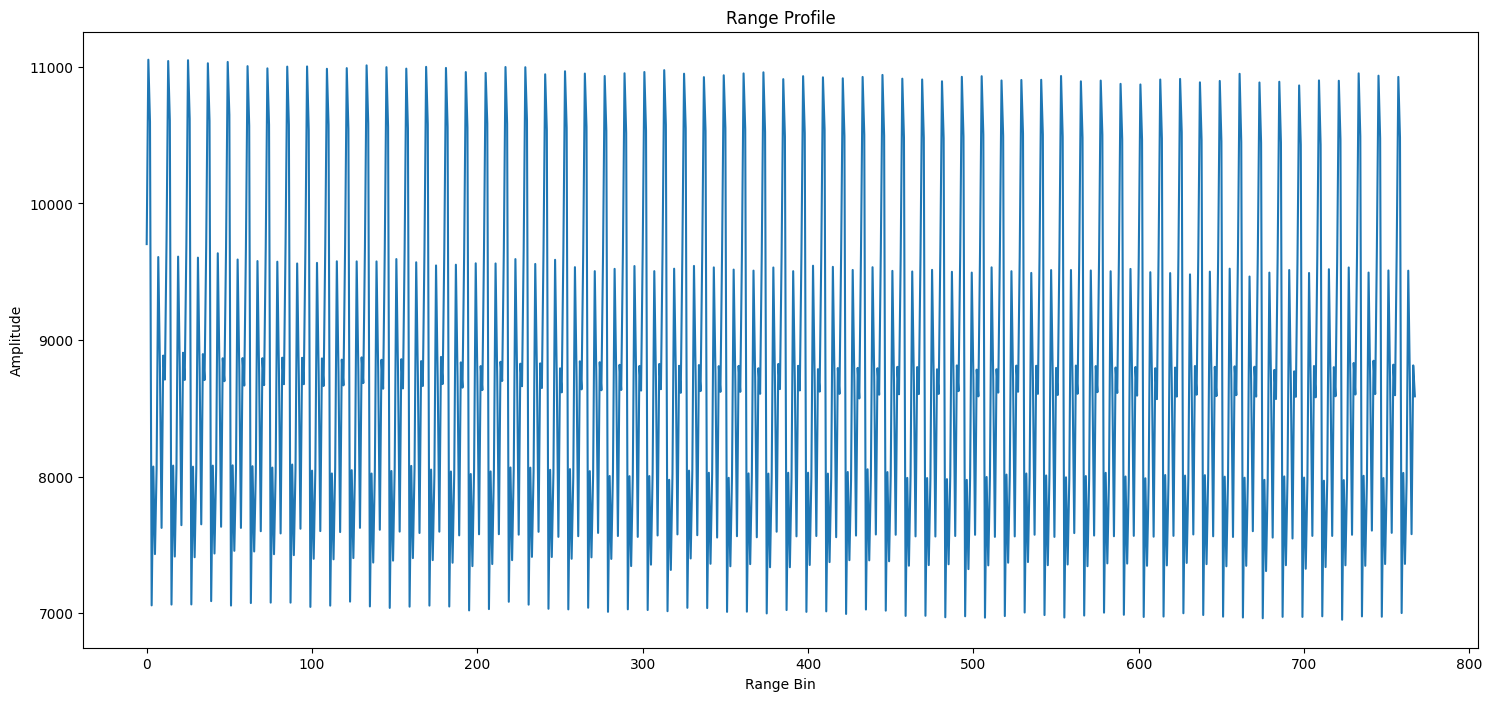

Processed chunk 1
Processed chunk 2
Processed chunk 3
No more data from all devices. Processing completed.


In [8]:
# main process loop
doppler_spectrum_accum = None  # Initialize accumulator
total_chunks_processed = 0

while True:
    chunk_device_data = {}
    all_devices_have_data = True
    for device in devices:
        try:
            adc_data_complex_chunk = next(device_generators[device])
            chunk_device_data[device] = adc_data_complex_chunk
        except StopIteration:
            all_devices_have_data = False
            break  # Stop processing if any device has no more data

    if not all_devices_have_data:
        print("No more data from all devices. Processing completed.")
        break  # Exit the while loop

    num_frames_in_chunk = chunk_device_data[devices[0]].shape[0]  # Number of frames in the chunk

    # Construct virtual antenna array for the chunk
    virtual_data_chunk = construct_virtual_array(
        device_data_chunk=chunk_device_data,
        num_frames_in_chunk=num_frames_in_chunk,
        num_chirps_per_frame=num_chirps_per_frame,
        num_rx=num_rx,
        num_adc_samples=num_adc_samples,
        chirp_tx_mapping=chirp_tx_mapping
    )

    # Perform Range FFT
    range_profiles_chunk = range_fft(virtual_data_chunk, num_adc_samples)

    # Identify the range bin corresponding to the drone (only once)
    if total_chunks_processed == 0:
        range_magnitude = np.abs(range_profiles_chunk)
        range_magnitude_mean = np.mean(range_magnitude, axis=(0, 2, 3))  # Average over frames, RX antennas, samples
        range_profile = range_magnitude_mean

        plt.figure(figsize=(18,8))
        plt.plot(range_profile)
        plt.title('Range Profile')
        plt.xlabel('Range Bin')
        plt.ylabel('Amplitude')
        plt.show()

        selected_range_bin = int(input("Enter the index of the range bin corresponding to the drone: "))

    # Perform Doppler FFT
    doppler_spectrum_chunk = doppler_fft(range_profiles_chunk, num_chirps_per_frame)

    # Extract Doppler spectrum for the selected range bin
    doppler_spectrum_selected = doppler_spectrum_chunk[:, :, :, selected_range_bin]
    doppler_spectrum_mean = np.mean(doppler_spectrum_selected, axis=2)  # Average over RX antennas
    doppler_spectrum_sum = np.sum(doppler_spectrum_mean, axis=0)        # Sum over frames in the chunk

    # Accumulate Doppler spectrum
    if doppler_spectrum_accum is None:
        doppler_spectrum_accum = doppler_spectrum_sum
    else:
        doppler_spectrum_accum += doppler_spectrum_sum

    total_chunks_processed += 1
    print(f"Processed chunk {total_chunks_processed}")


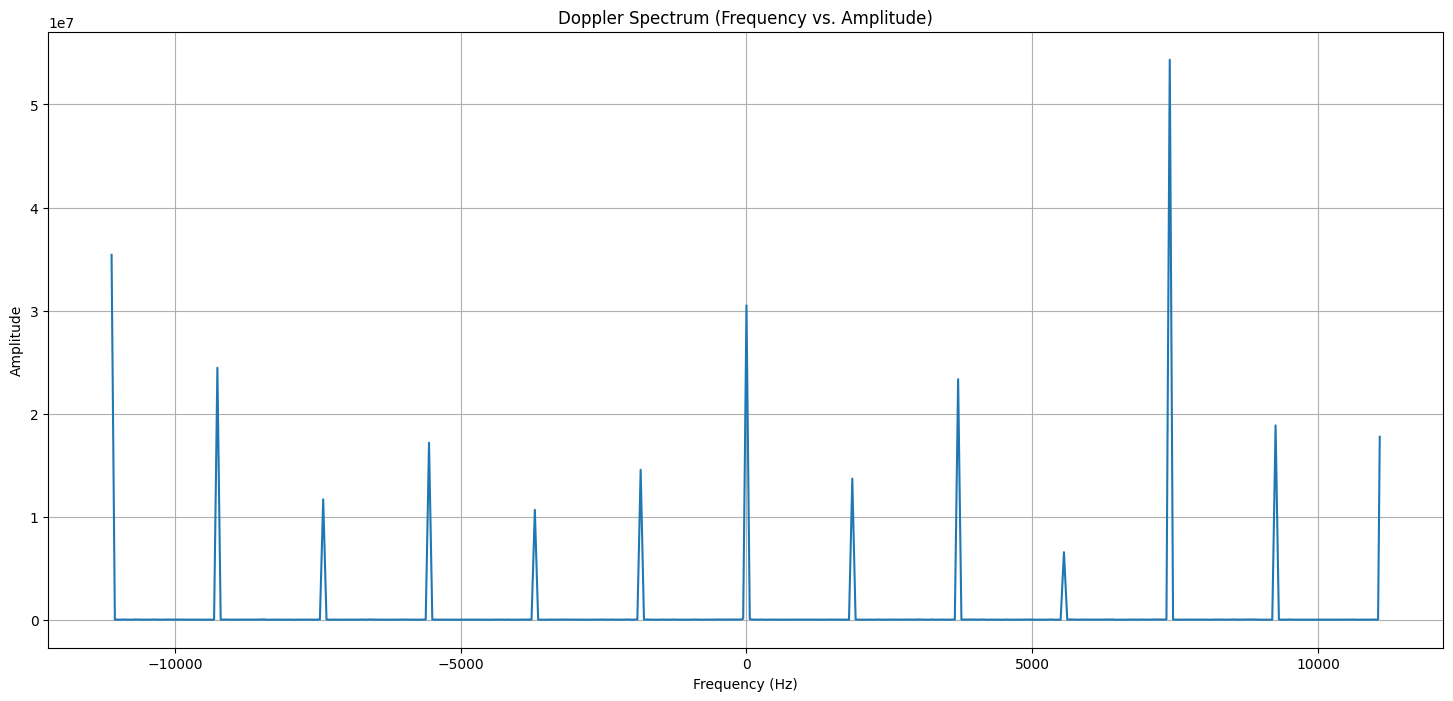

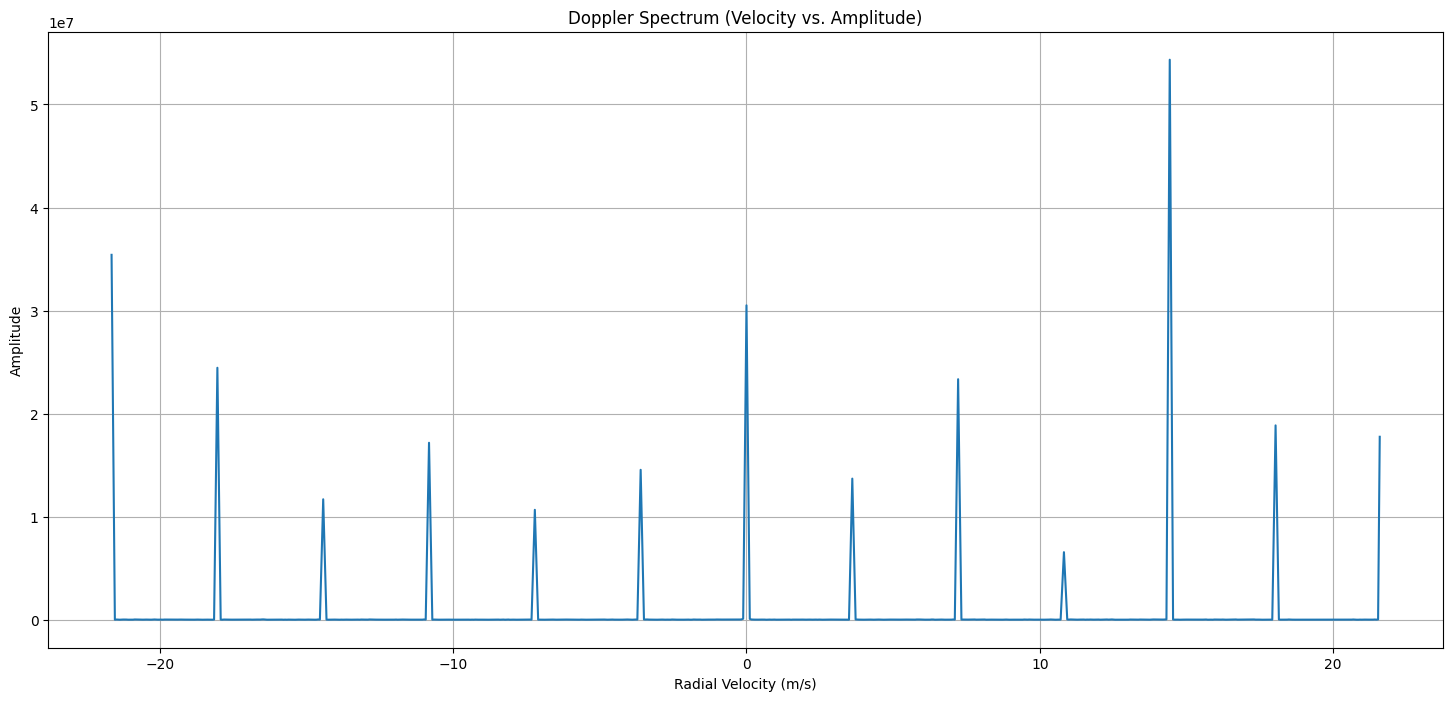

In [9]:
# Generate frequency and velocity axes
doppler_fft_size = num_chirps_per_frame
freq_bins = np.fft.fftshift(np.fft.fftfreq(doppler_fft_size, d=Tc))
velocity_bins = freq_bins * wavelength / 2

# Plot the Doppler Spectrum (Frequency vs. Amplitude)
amplitude_spectrum = np.abs(doppler_spectrum_accum)

plt.figure(figsize=(18,8))
plt.plot(freq_bins, amplitude_spectrum)
plt.title('Doppler Spectrum (Frequency vs. Amplitude)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Optional: Plot the Doppler Spectrum (Velocity vs. Amplitude)
plt.figure(figsize=(18,8))
plt.plot(velocity_bins, amplitude_spectrum)
plt.title('Doppler Spectrum (Velocity vs. Amplitude)')
plt.xlabel('Radial Velocity (m/s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
